# Blood Sugar Simulator

## Question
In general, eating food raises blood sugar and exercise lowers blood sugar.  We have created a simplified model of how these factors affect blood sugar.  Write a simulator that accepts several inputs of two types, food and exercise, each with a timestamp.  The output should be a “graph” of blood sugar over the course of the day, and a graph of the amount of “glycation” that occurred during the day.  

* Food:

In our model, eating food will increase blood sugar linearly for two hours.  The rate of increase depends on the food as defined in a database that we will provide.  See the glycemic index column. So if a food had a glycemic index of 50, and you eat at time 0, when blood sugar is 80. At T=1 hour blood sugar will be 105 and at T=2 hours, blood sugar will be 130. (NOTE this is only loosely based on science)

* Exercise:

Exercise decreases blood sugar linearly for one hour.

* Normalization:

Blood sugar starts at 80 at the beginning of the day. If neither food nor exercise is affecting your blood sugar (it has been more than 1 or 2 hours), it will approach 80 linearly at a rate of 1 per minute.

* Glycation:

For every minute your blood sugar stays above 150, increment “glycation” by 1.  This is a measure of how much crystallized sugar is accumulating in your blood stream which increases heart disease risk.


## Simulator
This is a simple simulator for blood sugar change by eating food or doing exercise.

Assume all the blood sugar change is in linear scale always, for example, even if the blood sugar is
very low (50), the exercise still reduces it further down no matter what.

Based on this assumption, this simulator is able to optimize the calculation by getting the gradient
(aka derivative) and total sugar in the key timestamps, then calculate the sugar value by linear interpolation.

See algorithm details in `blood_sugar_simulator/simulator.py`.

## Environment
You need to install `matplotlib`, `pandas`, `numpy`.

Usage:

In this direcotory, run:

```ipython3 notebook```

## The food and exercise list

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from blood_sugar_simulator import datautil, simulator

In [2]:
def dict_to_df(input_dict):
    return pd.DataFrame([(i.type, i.name, i.total_sugar, i.elapse_in_hour)
              for i in input_dict.values()], columns=['type', 'name', 'sugar', 'elapse_in_hour'])

exer_dict = datautil.load_exercise_dict()
food_dict = datautil.load_food_dict()

display(dict_to_df(exer_dict))
display(dict_to_df(food_dict))

,type,name,sugar,elapse_in_hour
0,DataType.EXERCISE,Crunches,-20,1
1,DataType.EXERCISE,Walking,-15,1
2,DataType.EXERCISE,Running,-40,1
3,DataType.EXERCISE,Sprinting,-60,1
4,DataType.EXERCISE,Squats,-60,1
5,DataType.EXERCISE,Bench press,-45,1


,type,name,sugar,elapse_in_hour
0,DataType.FOOD,"Banana cake, made with sugar",47,2
1,DataType.FOOD,"Banana cake, made without sugar",55,2
2,DataType.FOOD,"Sponge cake, plain",46,2
3,DataType.FOOD,Vanilla cake made from packet mix with vanilla...,42,2
4,DataType.FOOD,"Apple, made with sugar",44,2
5,DataType.FOOD,"Apple, made without sugar",48,2
6,DataType.FOOD,"Waffles, Aunt Jemima (Quaker Oats)",76,2
7,DataType.FOOD,"Bagel, white, frozen",72,2
8,DataType.FOOD,"Baguette, white, plain",95,2
9,DataType.FOOD,"Coarse barley bread, 75-80% kernels, average",34,2


In [4]:
# pick up the food or exercise id above, with volume (aka serving size).

actions = [
    # breakfast
    datautil.Action('07:10', datautil.DataType.FOOD, id=18, volume=1.0),
    datautil.Action('07:20', datautil.DataType.FOOD, id=77, volume=0.8),

    # exercise
    datautil.Action('08:50', datautil.DataType.EXERCISE, id=2, volume=0.7),

    # lunch
    datautil.Action('12:10', datautil.DataType.FOOD, id=121, volume=0.5),
    datautil.Action('12:20', datautil.DataType.FOOD, id=111, volume=0.5),

    # snack
    datautil.Action('14:20', datautil.DataType.FOOD, id=81, volume=0.3),

    # exercise
    datautil.Action('15:20', datautil.DataType.EXERCISE, id=6, volume=0.5),

    # dinner
    datautil.Action('18:30', datautil.DataType.FOOD, id=120, volume=0.3),
    datautil.Action('18:40', datautil.DataType.FOOD, id=21, volume=0.4),
    datautil.Action('18:50', datautil.DataType.FOOD, id=20, volume=0.2),

    # exercise
    datautil.Action('20:30', datautil.DataType.EXERCISE, id=3, volume=0.5),
]

granularity_in_minute = 5

results, events_start = simulator.start(actions, granularity_in_minute)

print('\n==== events ====')
for e in events_start:
    print(e.to_string())

print('\n==== glycation ====')
minutes = simulator.glycation(results, granularity_in_minute)
print('\n{0} minutes in high blood sugar'.format(minutes))



==== events ====
index=86, hhmm=07:10, status=begin, sugar_grad=2.125, name=100% Whole Grain™ bread (Natural Ovens)
index=88, hhmm=07:20, status=begin, sugar_grad=1.6, name=Pear, average
index=106, hhmm=08:50, status=begin, sugar_grad=-1.3125, name=Walking
index=107, hhmm=08:55, status= end , sugar_grad=1.6, name=Pear, average
index=110, hhmm=09:10, status= end , sugar_grad=2.125, name=100% Whole Grain™ bread (Natural Ovens)
index=114, hhmm=09:30, status= end , sugar_grad=-1.3125, name=Walking
index=146, hhmm=12:10, status=begin, sugar_grad=3.3333333333333335, name=Pizza, plain baked dough, served with parmesan cheese and tomato sauce
index=148, hhmm=12:20, status=begin, sugar_grad=1.4583333333333333, name=Carrots, average
index=158, hhmm=13:10, status= end , sugar_grad=3.3333333333333335, name=Pizza, plain baked dough, served with parmesan cheese and tomato sauce
index=160, hhmm=13:20, status= end , sugar_grad=1.4583333333333333, name=Carrots, average
index=172, hhmm=14:20, status=be

In [5]:
sugars = [(r.hhmm, r.sugar) for r in results]
df = pd.DataFrame(sugars, columns=['time', 'blood_sugar']).sort_values(by='time').set_index('time')
df.describe()

,blood_sugar
count,288.000000
mean,92.385590
std,24.484266
min,58.700000
25%,80.000000
50%,82.500000
75%,92.881250
max,173.700000


86 07:10 100% Whole Grain™ bread (Natural Ovens)
88 07:20 Pear, average
106 08:50 Walking
146 12:10 Pizza, plain baked dough, served with parmesan cheese and tomato sauce
148 12:20 Carrots, average
172 14:20 Watermelon
184 15:20 Bench press
222 18:30 Chicken nuggets, frozen, reheated in microwave oven 5 min
224 18:40 Wheat tortilla
226 18:50 Corn tortilla
246 20:30 Running


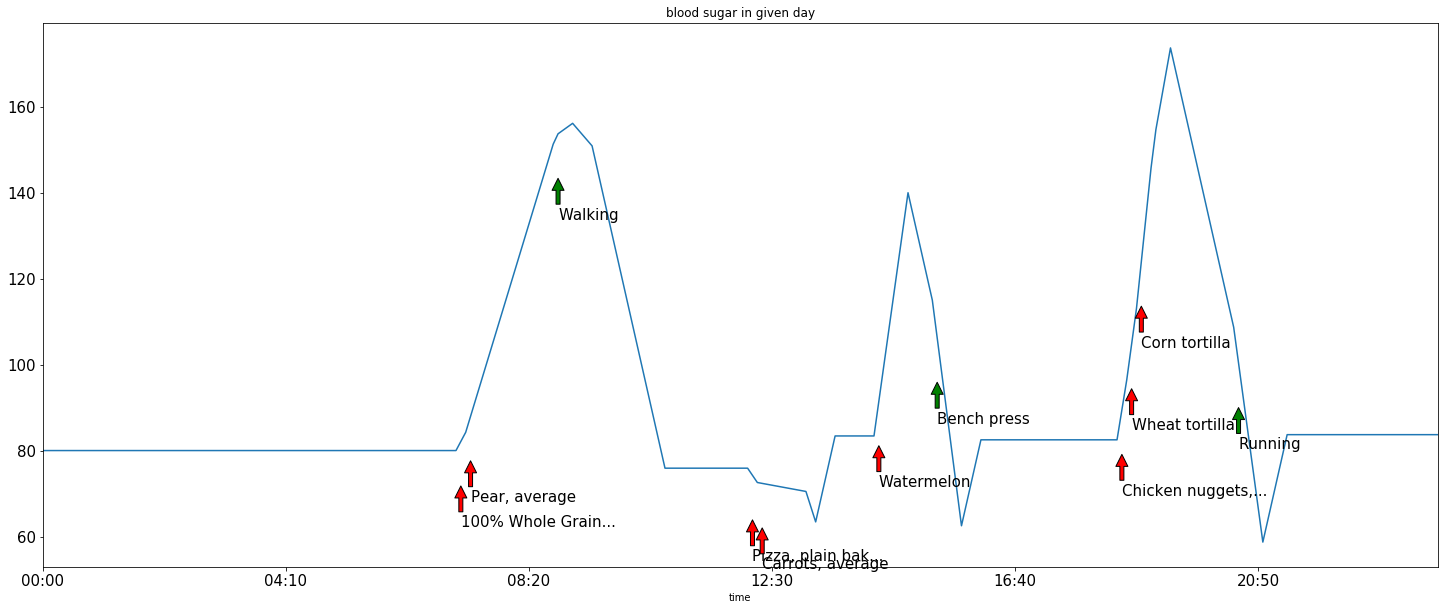

In [6]:
plot_df = df.loc[:, 'blood_sugar']
plt.figure()
ax = plot_df.plot(kind='line', figsize=(25, 10), title='blood sugar in given day', fontsize=15)

for e in events_start:
    if e.status == 'begin':
        x = e.index
        y = results[x].sugar
        text = e.name
        print(x, e.hhmm, text)

        # adjust the text length
        if len(text) > 16:
            text_to_show = text[:16] + '...'
        else:
            text_to_show = text

        # adjust the arrow color
        if e.sugar_grad > 0:
            arrow = dict(facecolor='red', shrink=0.05)
        else:
            arrow = dict(facecolor='green', shrink=0.05)

        ax.annotate(text_to_show, xy=(x, y-10), xytext=(x, y-20), arrowprops=arrow, fontsize=15)
plt.show()